# Clasificacion de imágenes satelitales landasat a partir del modelo entrenado con los puntos de entrenamiento.

In [2]:
import rasterio 
from rasterio.plot import show
from rasterio.plot import show_hist
from matplotlib import pyplot as plt
import geopandas as gpd
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image
import numpy as np
import pickle

In [5]:
with open('random_forest_gs.pkl', 'rb') as file:
    randon_forest_gs_model = pickle.load(file)

In [6]:
with open('random_forest_rs.pkl', 'rb') as file:
    randon_forest_rs_model = pickle.load(file)

In [7]:
with open('decision_tree_example.pkl', 'rb') as file:
    decision_tree_model = pickle.load(file)

Cargamos la información la información de la imagen satelital

In [8]:

lingue_7b = rasterio.open('./lingue_basin_img_7b_ord_final.tif')
lingue_7b.crs

CRS.from_epsg(4326)

# Tenemos que ajustar la imagen original a una dimension adecuada para utilizar el predict

In [9]:
# Leemos la imagen como un array
lingue_7b_array = lingue_7b.read()  ## 
lingue_7b_array.shape

(7, 918, 1530)

In [10]:
### Debemos reemplazar los nan de las imagenes por 0

np.isnan(lingue_7b_array).sum()

4504122

In [11]:
lingue_7b_array = np.nan_to_num(lingue_7b_array, nan = 0.0)

In [12]:
# Reshape desde array a imagen
lingue_7b_image = reshape_as_image(lingue_7b_array)
print(lingue_7b_image.shape)

(918, 1530, 7)


In [13]:
# Volvemos hacer un reshape de a -1,7
class_prediction_randon_forest_gs_model = randon_forest_gs_model.predict(lingue_7b_image.reshape(-1,7))

In [14]:
class_prediction_randon_forest_gs_model 

array([1., 1., 1., ..., 1., 1., 1.])

In [15]:
class_prediction_matrix = class_prediction_randon_forest_gs_model .reshape(lingue_7b_image[:,:,0].shape)
class_prediction_matrix.shape

(918, 1530)

In [16]:
type(class_prediction_matrix)

numpy.ndarray

In [17]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction_matrix))

# next setup a colormap for our map
colors = dict((
    (1, (52, 78, 31, 255)),   # Forest plantation - Darkgreen
    (2, (27,255, 1, 255)),      # Green - Native Forest
    (3, (1, 255, 214, 255)),    # Lightblue - Emergent Grassland
    (4, (255, 1, 1, 255)),      # Urbano 
    (5, (239, 255, 1, 255)),          # Suelo descubierto
    (6, (1, 18, 255, 255))      # Water
   
    
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (0, 0, 0, 255) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

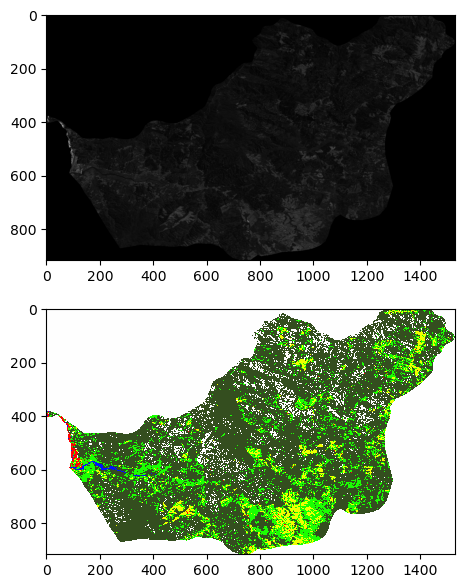

In [19]:
fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(lingue_7b_image, [2, 2, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction_matrix, cmap=cmap, interpolation='none')



In [20]:
class_prediction_matrix.dtype

dtype('float64')

In [21]:
# Assuming 'class_prediction_matrix' is your numpy array
class_prediction_matrix = class_prediction_matrix.astype(np.int8)

Exportar A tif usando rasterio (OTras formas usando fifffile library existen tambien)

In [22]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

In [23]:
# Array
print(class_prediction_matrix.shape)

(918, 1530)


In [24]:
# Define the bounds of your desired extent
left, bottom, right, top = (-123.5, 48.0, -122.0, 49.5)

In [25]:
left, bottom, right, top = (-73.2448553429124871,-39.5329691920034918, -72.8325286275016310,-39.2855731627569753)

In [26]:
height = class_prediction_matrix.shape[0]
width = class_prediction_matrix.shape[1]

In [27]:
# Create a transform from the bounds
from rasterio.transform import from_bounds
transform = from_bounds(left, bottom, right, top, width, height)

In [28]:
metadata = {
    'driver': 'GTiff',
    'height': class_prediction_matrix.shape[0],
    'width': class_prediction_matrix.shape[1],
    'count': 1,
    'dtype' : class_prediction_matrix.dtype,
    'crs': '+proj=longlat +datum=WGS84 +no_defs +type=crs',
    'transform':transform,
}

# Save the a TIFF file

with rasterio.open('clasificacion_lingue_rf_trans_final_agosto.tif','w', **metadata) as dst:
    dst.write(class_prediction_matrix,1)